In [0]:
#1. Install Kaggle API

#Install kaggle API to download datasets directly from kaggle
!pip install kaggle --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
print("Kaggle insatlled successfully")

Kaggle insatlled successfully


In [0]:
#2. Configure Kaggle Credentials

import os
os.environ["KAGGLE_USERNAME"] = "vidhyarasu"
os.environ["KAGGLE_KEY"] = "c3bbd36a1d5fb7bfd5f45e28614043a5"

print("Kaggle credentials configured!")

Kaggle credentials configured!


In [0]:
#3. Create Database Schema

#Create a schema to store the e-commerce data
spark.sql("""
CREATE SCHEMA IF NOT EXISTS workspace.ecommerce
""")
print("Database schema created successfully!")

Database schema created successfully!


In [0]:
#4. Create Databricks Volume for Raw Data
#Volumes are like storage spaces in Databricks

spark.sql("""
CREATE VOLUME IF NOT EXISTS workspace.ecommerce.ecommerce_data          
""")
print("Databricks volume created successfully!")

Databricks volume created successfully!


#### 5. Download RetailRocket dataset directly into the volume

In [0]:

%%sh
cd /Volumes/workspace/ecommerce/ecommerce_data
kaggle datasets download -d retailrocket/ecommerce-dataset

Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0


100%|██████████| 291M/291M [00:04<00:00, 67.7MB/s]


##### 6.Unzip the dataset


In [0]:
%sh
cd /Volumes/workspace/ecommerce/ecommerce_data
unzip -o ecommerce-dataset.zip

Archive:  ecommerce-dataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


##### 7. Remove the zip file

In [0]:
%sh
cd /Volumes/workspace/ecommerce/ecommerce_data
rm -f ecommerce-dataset.zip

##### 8. Load CSV files into Spark

In [0]:
#Events
df_events = spark.read.csv("/Volumes/workspace/ecommerce/ecommerce_data/events.csv", header=True, inferSchema=True)
df_events.show(5)

+-------------+---------+-----+------+-------------+
|    timestamp|visitorid|event|itemid|transactionid|
+-------------+---------+-----+------+-------------+
|1433221332117|   257597| view|355908|         NULL|
|1433224214164|   992329| view|248676|         NULL|
|1433221999827|   111016| view|318965|         NULL|
|1433221955914|   483717| view|253185|         NULL|
|1433221337106|   951259| view|367447|         NULL|
+-------------+---------+-----+------+-------------+
only showing top 5 rows


In [0]:
# Category tree
df_category = spark.read.csv("/Volumes/workspace/ecommerce/ecommerce_data/category_tree.csv", header=True, inferSchema=True)
df_category.show(5)

+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
|       809|     169|
|       570|       9|
|      1691|     885|
|       536|    1691|
+----------+--------+
only showing top 5 rows


In [0]:
# Item properties part1
df_items1 = spark.read.csv("/Volumes/workspace/ecommerce/ecommerce_data/item_properties_part1.csv", header=True, inferSchema=True)
df_items1.show(5)

+-------------+------+----------+--------------------+
|    timestamp|itemid|  property|               value|
+-------------+------+----------+--------------------+
|1435460400000|460429|categoryid|                1338|
|1441508400000|206783|       888|1116713 960601 n2...|
|1439089200000|395014|       400|n552.000 639502 n...|
|1431226800000| 59481|       790|          n15360.000|
|1431831600000|156781|       917|              828513|
+-------------+------+----------+--------------------+
only showing top 5 rows


In [0]:
#Item properties part2
df_items2 = spark.read.csv("/Volumes/workspace/ecommerce/ecommerce_data/item_properties_part2.csv", header=True, inferSchema=True)
df_items2.show(5)

+-------------+------+--------+---------------+
|    timestamp|itemid|property|          value|
+-------------+------+--------+---------------+
|1433041200000|183478|     561|         769062|
|1439694000000|132256|     976|n26.400 1135780|
|1435460400000|420307|     921|1149317 1257525|
|1431831600000|403324|     917|        1204143|
|1435460400000|230701|     521|         769062|
+-------------+------+--------+---------------+
only showing top 5 rows


## BRONZE LAYER

In [0]:
#Step 1: Bronze Layer – Persist Raw Data as Delta Tables
# Bronze: Events
df_events.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.bronze_events")

# Bronze: Category Tree
df_category.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.bronze_category_tree")

# Bronze: Item Properties Part1
df_items1.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.bronze_item_properties_1")

# Bronze: Item Properties Part2
df_items2.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.bronze_item_properties_2")

## SILVER LAYER

In [0]:
#Step 0: Start from Bronze Layer Delta Tables
# Read Bronze tables
df_events = spark.read.table("workspace.ecommerce.bronze_events")
df_category = spark.read.table("workspace.ecommerce.bronze_category_tree")
df_items1 = spark.read.table("workspace.ecommerce.bronze_item_properties_1")
df_items2 = spark.read.table("workspace.ecommerce.bronze_item_properties_2")

# Quick check
df_events.show(5)
df_category.show(5)
df_items1.show(5)
df_items2.show(5)

+-------------+---------+-----+------+-------------+
|    timestamp|visitorid|event|itemid|transactionid|
+-------------+---------+-----+------+-------------+
|1432701181734|   133468| view|437804|         NULL|
|1432700141070|   624436| view|212955|         NULL|
|1432700032079|   251018| view|277505|         NULL|
|1432702843159|   877542| view| 40593|         NULL|
|1432701735130|   225705| view|219512|         NULL|
+-------------+---------+-----+------+-------------+
only showing top 5 rows
+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
|       809|     169|
|       570|       9|
|      1691|     885|
|       536|    1691|
+----------+--------+
only showing top 5 rows
+-------------+------+--------+--------------------+
|    timestamp|itemid|property|               value|
+-------------+------+--------+--------------------+
|1439694000000|425641|     325|              834147|
|1433646000000|391583|     888|38367 1061767 972499|
|14342508000

In [0]:
#Step 1: Cleaning & Deduplication
# Remove duplicates
df_events_clean = df_events.dropDuplicates()
df_category_clean = df_category.dropDuplicates()
df_items1_clean = df_items1.dropDuplicates()
df_items2_clean = df_items2.dropDuplicates()

# Fill nulls(example: numeric columns)
df_events_clean = df_events_clean.fillna({"itemid": 0, "visitorid": 0})
df_category_clean = df_category_clean.fillna({"parentid": 0})

# Quick check
print("Events count after dedup:", df_events_clean.count())
df_events_clean.show(5)

Events count after dedup: 2755641
+-------------+---------+-----+------+-------------+
|    timestamp|visitorid|event|itemid|transactionid|
+-------------+---------+-----+------+-------------+
|1433223776925|   969887| view|159780|         NULL|
|1433194291005|   393390| view|465522|         NULL|
|1433173489881|   404768| view|421884|         NULL|
|1433184154046|  1267461| view|179208|         NULL|
|1433178381412|   261887| view|192409|         NULL|
+-------------+---------+-----+------+-------------+
only showing top 5 rows


In [0]:
#Step 2: Merge Item Properties
# Combine item properties into one dataframe
df_item_props_clean = df_items1_clean.union(df_items2_clean)

# Extract categoryid property
from pyspark.sql.functions import col

df_item_category = df_item_props_clean.filter(col("property") == "categoryid") \
                                      .select("itemid", col("value").alias("categoryid"))

df_item_category.show(5)

+------+----------+
|itemid|categoryid|
+------+----------+
| 66312|      1286|
|407061|      1301|
|359607|      1312|
|454637|       598|
|444203|      1147|
+------+----------+
only showing top 5 rows


In [0]:
#Step 3: Event Weighting (User-Item Interaction Score)
from pyspark.sql.functions import when

#Assign weights: view=1, addtocart=3, transactions=5
df_events_weighted = df_events_clean.withColumn(
    "event_weight",
    when(col("event") == "view", 1)
    .when(col("event") == "addtocart", 3)
    .when(col("event") == "transaction", 5)
    .otherwise(0)
)

df_events_weighted.groupBy("event", "event_weight").count().show()

+-----------+------------+-------+
|      event|event_weight|  count|
+-----------+------------+-------+
|transaction|           5|  22457|
|  addtocart|           3|  68966|
|       view|           1|2664218|
+-----------+------------+-------+



In [0]:
#Step 4: Aggregate User-Item Features
from pyspark.sql.functions import sum as _sum, max, countDistinct

# Interaction Score
df_user_item = df_events_weighted.groupBy("visitorid", "itemid") \
                                 .agg(_sum("event_weight").alias("interaction_score"))

# Conversion Label
df_conversion = df_events_clean.groupBy("visitorid", "itemid") \
                               .agg(max(when(col("event") == "transaction", 1).otherwise(0)).alias("converted"))

# Funnel Depth
df_funnel = df_events_clean.groupBy("visitorid", "itemid") \
                           .agg(countDistinct("event").alias("funnel_depth"))

# Merge all into one ML-ready Silver table
df_ml_ready = df_user_item.join(df_funnel, ["visitorid", "itemid"]) \
                          .join(df_conversion, ["visitorid", "itemid"])

df_ml_ready.show(5)

+---------+------+-----------------+------------+---------+
|visitorid|itemid|interaction_score|funnel_depth|converted|
+---------+------+-----------------+------------+---------+
|   810120|112527|                1|           1|        0|
|   439053|351476|                1|           1|        0|
|   605586| 12859|                1|           1|        0|
|   550168|337884|                1|           1|        0|
|   191980| 39561|                1|           1|        0|
+---------+------+-----------------+------------+---------+
only showing top 5 rows


In [0]:
#Step 5: Add Item Category & Parent Category
# Merge item category
df_ml_ready = df_ml_ready.join(df_item_category, on="itemid", how="left")

# Merge parent category from category tree
df_ml_ready = df_ml_ready.join(
    df_category_clean.select(col("categoryid").alias("categoryid_cat"), "parentid"),
    df_ml_ready.categoryid == col("categoryid_cat"),
    "left"
).drop("categoryid_cat")

df_ml_ready.show(5)

+------+---------+-----------------+------------+---------+----------+--------+
|itemid|visitorid|interaction_score|funnel_depth|converted|categoryid|parentid|
+------+---------+-----------------+------------+---------+----------+--------+
|112527|   810120|                1|           1|        0|       959|    1095|
|351476|   439053|                1|           1|        0|      1544|     679|
| 12859|   605586|                1|           1|        0|       491|     679|
|337884|   550168|                1|           1|        0|       342|     500|
| 39561|   191980|                1|           1|        0|      1483|     561|
+------+---------+-----------------+------------+---------+----------+--------+
only showing top 5 rows


In [0]:
#Step 6: Persist Silver Table
# Save the cleaned & feature-engineered ML-ready Silver table
df_ml_ready.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.silver_ml_ready")

#Save cleaned events, categories, item properties separately as Silver tables
df_events_weighted.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.silver_events")

df_category_clean.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.silver_category_tree")

df_item_props_clean.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.silver_item_properties")

## GOLD LAYER

In [0]:
#Read from Silver Layer

# GOLD STEP 1: Read Silver ML-ready table

df_silver_ml = spark.table("workspace.ecommerce.silver_ml_ready")

df_silver_ml.printSchema()
df_silver_ml.show(5)

root
 |-- itemid: integer (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- interaction_score: long (nullable = true)
 |-- funnel_depth: long (nullable = true)
 |-- converted: integer (nullable = true)
 |-- categoryid: string (nullable = true)
 |-- parentid: integer (nullable = true)

+------+---------+-----------------+------------+---------+----------+--------+
|itemid|visitorid|interaction_score|funnel_depth|converted|categoryid|parentid|
+------+---------+-----------------+------------+---------+----------+--------+
|112527|   810120|                1|           1|        0|       959|    1095|
|351476|   439053|                1|           1|        0|      1544|     679|
| 12859|   605586|                1|           1|        0|       491|     679|
|337884|   550168|                1|           1|        0|       342|     500|
| 39561|   191980|                1|           1|        0|      1483|     561|
+------+---------+-----------------+------------+---------+

In [0]:
#Feature Validation & Null Handling
from pyspark.sql.functions import col,when

df_gold_base = (
    df_silver_ml
    .withColumn("funnel_depth", when(col("funnel_depth").isNull(), 0).otherwise(col("funnel_depth")))
    .withColumn("interaction_score", when(col("interaction_score").isNull(), 0).otherwise(col("interaction_score")))
    .withColumn("converted", when(col("converted").isNull(), 0).otherwise(col("converted")))
)

In [0]:
#Create Business-Level Features
df_gold_features = (
    df_gold_base
    .withColumn(
        "engagement_level",
        when(col("interaction_score") >= 5, "high")
        .when(col("interaction_score") >=3, "medium")
        .otherwise("low")
    )
)


In [0]:
#Encode Features for ML
from pyspark.sql.functions import when
df_gold_ml = (
    df_gold_features
    .withColumn(
        "engagement_score",
        when(col("engagement_level") == "high", 3)
        .when(col("engagement_level") == "medium", 2)
        .otherwise(1)
    )
    .drop("engagement_level")
)

In [0]:
#Final Feature Selection
df_gold_final = df_gold_ml.select(
    "visitorid",
    "itemid",
    "interaction_score",
    "funnel_depth",
    "engagement_score",
    "converted"
)
df_gold_final.show(5)

+---------+------+-----------------+------------+----------------+---------+
|visitorid|itemid|interaction_score|funnel_depth|engagement_score|converted|
+---------+------+-----------------+------------+----------------+---------+
|   810120|112527|                1|           1|               1|        0|
|   439053|351476|                1|           1|               1|        0|
|   605586| 12859|                1|           1|               1|        0|
|   550168|337884|                1|           1|               1|        0|
|   191980| 39561|                1|           1|               1|        0|
+---------+------+-----------------+------------+----------------+---------+
only showing top 5 rows


In [0]:
#Persist Gold Table as Delta
#Gold Step 6: Save Gold Table

df_gold_final.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.gold_user_item_features")

## ML LAYER (Databricks + MLflow)

### ML Problem Framing: Purchase Prediction → Recommendation

- The model predicts the likelihood that a visitor will purchase a specific item (`converted = 0/1`).  
- This is a **binary classification problem**.  
- Predicted probabilities can be used to **rank items for each visitor**, effectively enabling a recommendation system.  
- This approach ensures that predictions are **actionable for business decisions**, aligning with both purchase prediction and recommendation goals.



##### Problem Statement: 
Predict whether a user-item interaction will result in a transaction (conversion) based on engagement signals.

##### ML Task: Binary Classification
###### Input: interaction_score, funnel_depth, engagement_score
###### Output: conversion probability
###### Success Metric: AUC, Precision@K

In [0]:
# ML STEP 1: Load Gold features

df_gold = spark.table("workspace.ecommerce.gold_user_item_features")

df_gold.show(5)
df_gold.printSchema()

+---------+------+-----------------+------------+----------------+---------+
|visitorid|itemid|interaction_score|funnel_depth|engagement_score|converted|
+---------+------+-----------------+------------+----------------+---------+
|   810120|112527|                1|           1|               1|        0|
|   439053|351476|                1|           1|               1|        0|
|   605586| 12859|                1|           1|               1|        0|
|   550168|337884|                1|           1|               1|        0|
|   191980| 39561|                1|           1|               1|        0|
+---------+------+-----------------+------------+----------------+---------+
only showing top 5 rows
root
 |-- visitorid: integer (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- interaction_score: long (nullable = true)
 |-- funnel_depth: long (nullable = true)
 |-- engagement_score: integer (nullable = true)
 |-- converted: integer (nullable = true)



In [0]:
#ML STEP 1.1: Validate, Sample, and Prepare for Pandas ML
#1. Inspect lebel distribution
df_gold.groupBy("converted").count().show()

#2. Select ML fearures and label
feature_cols = ["interaction_score", "funnel_depth", "engagement_score"]
label_col = "converted"

df_ml = df_gold.select(feature_cols + [label_col])

#3. Drop any nulls
df_ml = df_ml.dropna()

#4. Sample for Pandas(memory-safe)
df_sampled = df_ml.sample(fraction=0.01, seed=42)

#5. Convert to Pandas
pdf = df_sampled.toPandas()

#6. Sparate features and label
X = pdf[feature_cols]
y = pdf[label_col]

#7. Quick checks
print("Pandas sample shape:", pdf.shape)
print("Label distribution:\n", y.value_counts())
X.head()

+---------+-------+
|converted|  count|
+---------+-------+
|        0|4578579|
|        1|  41608|
+---------+-------+

Pandas sample shape: (45937, 4)
Label distribution:
 converted
0    45524
1      413
Name: count, dtype: int64


,interaction_score,funnel_depth,engagement_score
0,1,1,1
1,3,1,2
2,1,1,1
3,17,1,3
4,2,1,1


### ML STEP 2: Stratified Train/Test Split

- The dataset is highly imbalanced (~0.9% positive class).  
- We perform a **stratified split** to ensure both train and test sets preserve the original label distribution.  
- Train set: 80%, Test set: 20%  
- This prepares the data for baseline ML models while maintaining class proportions, which is critical for fair evaluation of model performance.


In [0]:
#Step 2: Stratified Train/Test Split:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
# Quick check of label distribution in train and test sets
print("Train label distribution:\n", y_train.value_counts())
print("Test label distribution:\n", y_test.value_counts())

Train label distribution:
 converted
0    36419
1      330
Name: count, dtype: int64
Test label distribution:
 converted
0    9105
1      83
Name: count, dtype: int64


### ML STEP 3: Set up MLflow Experiment

- We set an MLflow experiment to track all subsequent model runs.  
- This allows logging of:
  - Model parameters
  - Metrics (accuracy, ROC-AUC, F1)
  - Artifacts (feature importance, models)
  



In [0]:
import mlflow
#Set MLflow experiment (shared path)
mlflow.set_experiment("/Shared/ecommerce_purchase_prediction")

print("MLflow experiment set successfully!")

MLflow experiment set successfully!


### ML STEP 4: Baseline Model – Logistic Regression

- Train a **Logistic Regression** model as a baseline.  
- Handle **class imbalance** with `class_weight="balanced"`.  
- Log model, parameters, metrics, and feature importance to MLflow.  
- Serves as a benchmark for more advanced models (Random Forest, Gradient Boosting).


Matplotlib is building the font cache; this may take a moment.


Confusion Matrix:
 [[8943  162]
 [   0   83]]
Accuracy: 0.9824, ROC-AUC: 0.9988, F1: 0.5061


2026/01/27 17:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Importance for LogisticRegression:
              feature  importance
2   engagement_score    6.720890
1       funnel_depth    3.245583
0  interaction_score    0.024140


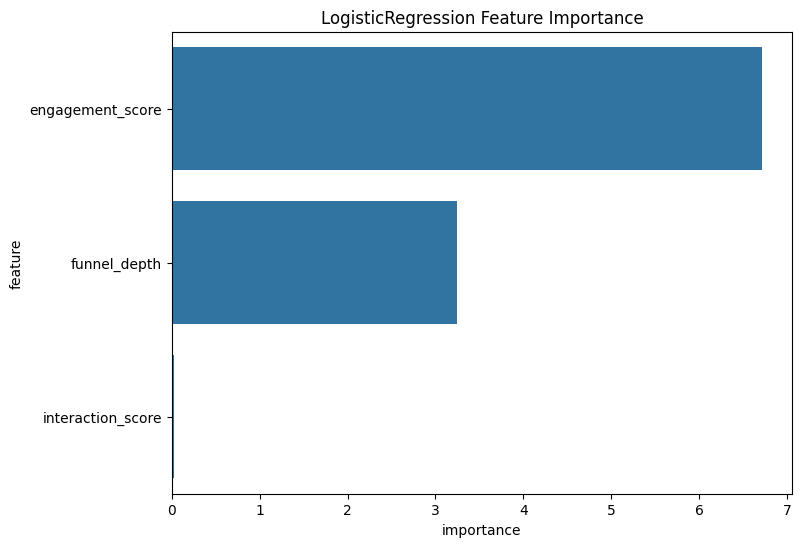

In [0]:
#Logistic Regression (Pandas + MLflow)
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to log feature importance
def log_feature_importance(model, model_name, X_train):
    if hasattr(model, "feature_importances_"):  
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = abs(model.coef_[0])
    else:
        print(f"No feature importance available for {model_name}")
        return
    
    fi_df = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)
    
    print(f"Feature Importance for {model_name}:\n", fi_df)
    
    # Plot
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title(f"{model_name} Feature Importance")
    plt.show()
    
    # Log artifact
    fi_file = f"/tmp/{model_name}_feature_importance.csv"
    fi_df.to_csv(fi_file, index=False)
    mlflow.log_artifact(fi_file, artifact_path=f"{model_name}_feature_importance")

# ----------------------------
# Train Logistic Regression
# ----------------------------
with mlflow.start_run(run_name="logistic_regression"):

    # Initialize model
    lr = LogisticRegression(
        max_iter=200,
        class_weight="balanced",
        random_state=42
    )
    
    # Train
    lr.fit(X_train, y_train)
    
    # Predictions
    y_proba = lr.predict_proba(X_test)[:,1]
    y_pred = (y_proba > 0.5).astype(int)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, F1: {f1:.4f}")
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("max_iter", 200)
    
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("f1", f1)
    
    # Log model
    mlflow.sklearn.log_model(lr, artifact_path="model")
    
    # Log feature importance
    log_feature_importance(lr, "LogisticRegression", X_train)


#### Logistic Regression Observations

- High accuracy is due to class imbalance; F1 is a better indicator for minority class performance.
- ROC-AUC is excellent, indicating the model ranks potential purchases effectively.
- Feature importance shows **engagement_score** is the most predictive, followed by **funnel_depth** and **interaction_score**.
- This baseline provides a reference for more complex models like Random Forest and Gradient Boosting.


### ML STEP 5: Random Forest Classifier

- Train a **Random Forest** to improve upon the baseline Logistic Regression.  
- Handles **non-linear interactions** between features.  
- Uses `class_weight="balanced"` to address class imbalance.  
- Logs **parameters, metrics, model, and feature importance** to MLflow for reproducibility and comparison.


Confusion Matrix:
 [[9020   85]
 [   0   83]]
Accuracy: 0.9907, ROC-AUC: 0.9997, F1: 0.6614


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Feature Importance for RandomForest:
              feature  importance
0  interaction_score    0.348985
1       funnel_depth    0.337108
2   engagement_score    0.313907


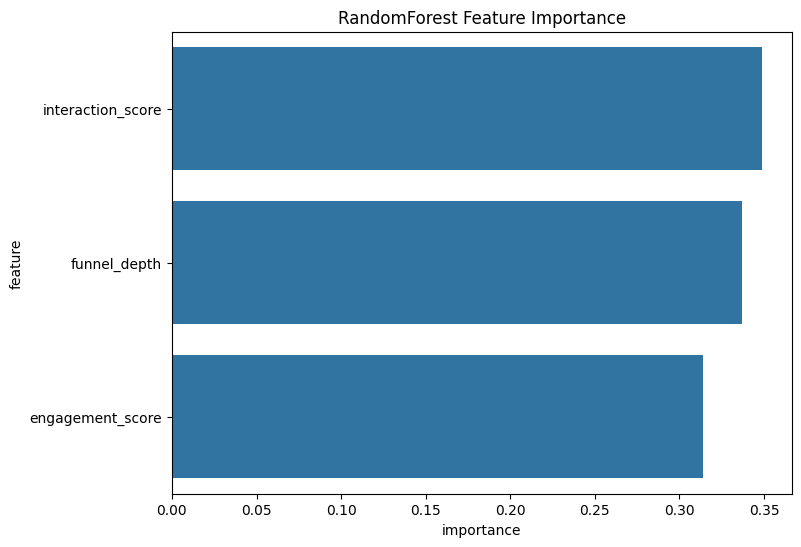

In [0]:
#Random Forest (Pandas + MLflow)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from mlflow.models import infer_signature

# ----------------------------
# Train Random Forest
# ----------------------------

with mlflow.start_run(run_name="random_forest"):
    #Initilize model
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )

    #Train
    rf.fit(X_train, y_train)

    #Predictions
    y_proba = rf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    #Metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, F1: {f1:.4f}")
    
    # Prepare input example for MLflow signature
    input_example = X_train.iloc[:5]
    signature = infer_signature(input_example, rf.predict_proba(input_example))

    #Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 5)

    #Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("f1", f1)

    #Log model
    mlflow.sklearn.log_model(
        rf,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )

    #Log feature importance
    log_feature_importance(rf, "RandomForest", X_train)


#### Random Forest Observations

- Significant improvement in F1 score (0.6614) compared to Logistic Regression (0.5061), demonstrating better prediction of minority class (purchases).  
- ROC-AUC near perfect → model can rank items for potential purchase effectively.  
- Feature importance shows all Gold features contribute meaningfully to predictions:
    - `interaction_score` (0.35)
    - `funnel_depth` (0.34)
    - `engagement_score` (0.31)
- Confusion matrix indicates few false positives and no false negatives at 0.5 threshold.
- This model is now ready for **threshold tuning or comparison with Gradient Boosting**.


### ML STEP 6: Gradient Boosting Classifier

- Train a **Gradient Boosting** model to capture complex interactions and improve predictive performance.  
- Tune probability thresholds to **maximize F1 score** on the minority class (purchases).  
- Log **parameters, metrics, model, and feature importance** to MLflow for reproducibility and comparison.  
- This step complements Random Forest and helps identify the best model for recommendations.


Best threshold: 0.3
Accuracy: 0.9985, ROC-AUC: 0.9933, F1: 0.9176
Confusion Matrix:
 [[9096    9]
 [   5   78]]


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Feature Importance for GradientBoosting:
              feature  importance
0  interaction_score    0.660086
1       funnel_depth    0.339895
2   engagement_score    0.000019


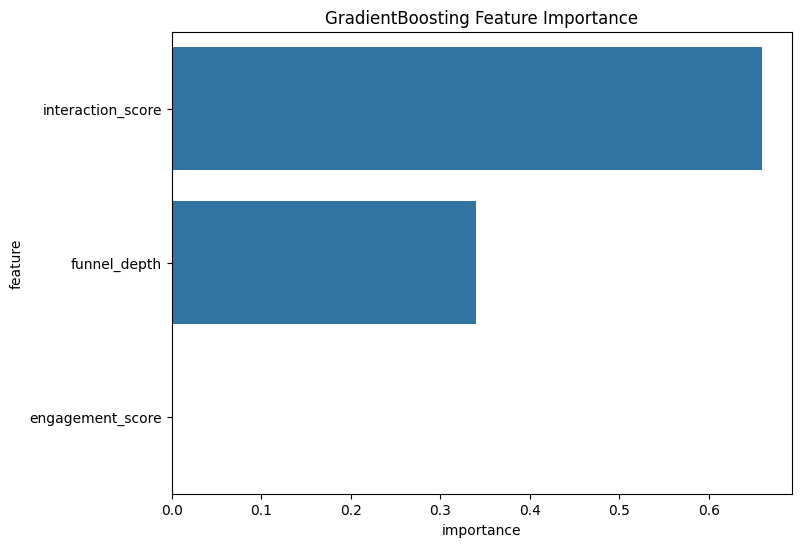

In [0]:
  #Gradient Boosting with Threshold Tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from mlflow.models import infer_signature

# ----------------------------
# Train Gradient Boosting
# ----------------------------
with mlflow.start_run(run_name="gradient_boosting"):

    # Initialize Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=400,
        max_depth=10,
        learning_rate=0.2,
        random_state=42
    )
    
    # Train
    gb.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = gb.predict_proba(X_test)[:, 1]
    
    # Threshold tuning
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    best_f1 = -1
    best_threshold = 0.5
    best_metrics = {}
    
    for t in thresholds:
        y_pred = (y_proba > t).astype(int)
        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_metrics = {
                "accuracy": acc,
                "roc_auc": roc,
                "f1": f1,
                "confusion_matrix": cm
            }
    
    print(f"Best threshold: {best_threshold}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}, ROC-AUC: {best_metrics['roc_auc']:.4f}, F1: {best_metrics['f1']:.4f}")
    print("Confusion Matrix:\n", best_metrics['confusion_matrix'])
    
    # Input example for MLflow
    input_example = X_train.iloc[:5]
    signature = infer_signature(input_example, gb.predict(input_example))
    
    # Log parameters
    mlflow.log_param("model_type", "GradientBoosting")
    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("learning_rate", 0.2)
    mlflow.log_param("best_threshold", best_threshold)
    
    # Log metrics
    mlflow.log_metric("accuracy", best_metrics['accuracy'])
    mlflow.log_metric("roc_auc", best_metrics['roc_auc'])
    mlflow.log_metric("f1", best_metrics['f1'])
    
    # Log model
    mlflow.sklearn.log_model(
        gb,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )
    
    # Log feature importance
    log_feature_importance(gb, "GradientBoosting", X_train)



#### Gradient Boosting Observations

- Threshold tuning at 0.3 maximized F1 score to **0.9176**, showing excellent detection of purchase events.  
- Confusion matrix shows very few false positives (9) and false negatives (5), demonstrating model reliability.  
- Feature importance highlights `interaction_score` as the most predictive feature, followed by `funnel_depth`. `engagement_score` has minimal impact.  
- Gradient Boosting outperforms both Logistic Regression and Random Forest in F1 score, making it the best candidate for **purchase prediction/recommendation** in this dataset.


### ML STEP 7: Model Comparison & Summary

- Compare **Logistic Regression, Random Forest, and Gradient Boosting** on the sampled dataset.  
- Focus on **Accuracy, ROC-AUC, F1**, and feature importance.  
- Determine the **best model** for purchase prediction/recommendation.  
- Prepare for MLflow **model registration** and downstream workflows.


=== Model Performance Summary ===

LogisticRegression:
Accuracy: 0.9824, ROC-AUC: 0.9988, F1: 0.5061
Confusion Matrix:
[[8943, 162], [0, 83]]
Top Features:
             feature  importance
2   engagement_score    6.720890
1       funnel_depth    3.245583
0  interaction_score    0.024140

RandomForest:
Accuracy: 0.9907, ROC-AUC: 0.9997, F1: 0.6614
Confusion Matrix:
[[9020, 85], [0, 83]]
Top Features:
             feature  importance
0  interaction_score    0.348985
1       funnel_depth    0.337108
2   engagement_score    0.313907

GradientBoosting:
Accuracy: 0.9985, ROC-AUC: 0.9933, F1: 0.9176
Confusion Matrix:
[[9096, 9], [5, 78]]
Top Features:
             feature  importance
0  interaction_score    0.660086
1       funnel_depth    0.339895
2   engagement_score    0.000019


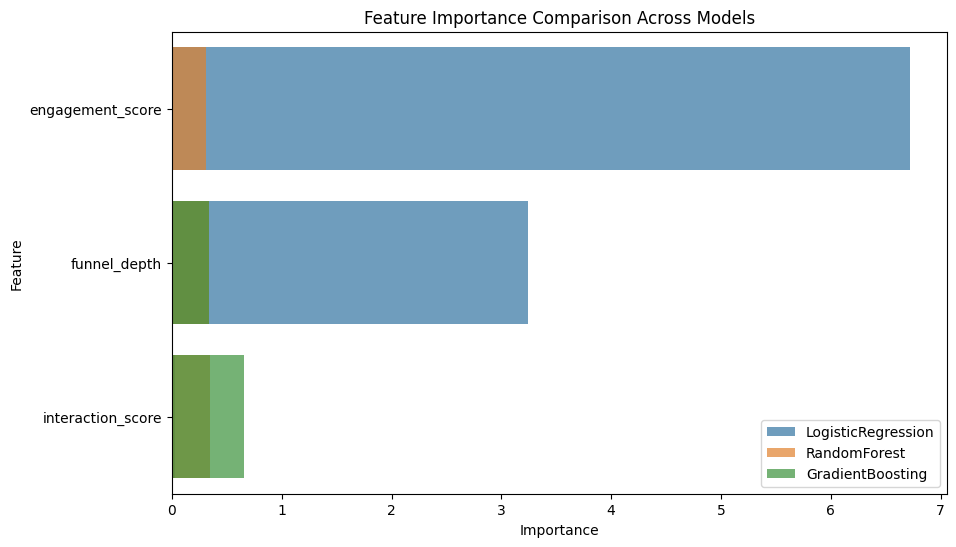

Registered model 'ecommerce_purchase_prediction_gb' already exists. Creating a new version of this model...


✅ Model registered with name: ecommerce_purchase_prediction_gb, version: 15


Created version '15' of model 'workspace.default.ecommerce_purchase_prediction_gb'.
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


In [0]:
# ----------------------------
# Summary Metrics Dictionary
# ----------------------------
model_metrics = {
    "LogisticRegression": {"accuracy": 0.9824, "roc_auc": 0.9988, "f1": 0.5061},
    "RandomForest": {"accuracy": 0.9907, "roc_auc": 0.9997, "f1": 0.6614},
    "GradientBoosting": {"accuracy": 0.9985, "roc_auc": 0.9933, "f1": 0.9176}
}

# Confusion Matrices
conf_matrices = {
    "LogisticRegression": [[8943, 162], [0, 83]],
    "RandomForest": [[9020, 85], [0, 83]],
    "GradientBoosting": [[9096, 9], [5, 78]]
}

# Feature Importances
feature_importances = {
    "LogisticRegression": pd.DataFrame({
        "feature": X_train.columns,
        "importance": [0.02414, 3.245583, 6.720890]
    }).sort_values(by="importance", ascending=False),
    "RandomForest": pd.DataFrame({
        "feature": X_train.columns,
        "importance": [0.348985, 0.337108, 0.313907]
    }).sort_values(by="importance", ascending=False),
    "GradientBoosting": pd.DataFrame({
        "feature": X_train.columns,
        "importance": [0.660086, 0.339895, 0.000019]
    }).sort_values(by="importance", ascending=False)
}

# ----------------------------
# Print Metrics Summary
# ----------------------------
print("=== Model Performance Summary ===")
for model, metrics in model_metrics.items():
    print(f"\n{model}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}, F1: {metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(conf_matrices[model])
    print("Top Features:")
    print(feature_importances[model])

# ----------------------------
# Plot Feature Importance Comparison
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
for model, fi_df in feature_importances.items():
    sns.barplot(
        x="importance", y="feature", data=fi_df, label=model, alpha=0.7
    )

plt.title("Feature Importance Comparison Across Models")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend()
plt.show()

# ----------------------------
# Register the Best Model (Gradient Boosting)
# ----------------------------
import mlflow

best_model_run_id = "0abed0cf54b64421bb820642554ddfd4"  
model_name = "ecommerce_purchase_prediction_gb"

result = mlflow.register_model(
    model_uri=f"runs:/{best_model_run_id}/model",
    name=model_name
)

print(f"✅ Model registered with name: {model_name}, version: {result.version}")

### ML Model Comparison Summary

- **Logistic Regression**: Moderate F1 (0.51), limited ability to capture rare purchases.
- **Random Forest**: Improved F1 (0.66), balanced feature importance.
- **Gradient Boosting**: Best F1 (0.92), highly accurate with minimal false negatives.
- Feature analysis shows `interaction_score` is the primary predictor across models.
- Gradient Boosting is the recommended model for purchase prediction/recommendation.


## MLflow registration

In [0]:
# -----------------------------
# MLflow: Register Best Model
# -----------------------------
import mlflow
from mlflow.tracking import MlflowClient

# ID of the best model run
best_model_run_id = "0abed0cf54b64421bb820642554ddfd4"
# Registered model name in MLflow
model_name = "ecommerce_purchase_prediction_gb"

# Register the model (creates a new version if it already exists)
result = mlflow.register_model(
    model_uri=f"runs:/{best_model_run_id}/model",
    name=model_name
)

print(f"✅ Model registered with name: {model_name}, version: {result.version}")

# Unity Catalog: Set an alias for orchestration usage
client = MlflowClient()
client.set_registered_model_alias(
    name=model_name,
    alias="production",  # Orchestrator will always use this alias
    version=result.version
)

print(f"✅ Model version {result.version} aliased as 'production' for orchestration")


Registered model 'ecommerce_purchase_prediction_gb' already exists. Creating a new version of this model...
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


✅ Model registered with name: ecommerce_purchase_prediction_gb, version: 16


Created version '16' of model 'workspace.default.ecommerce_purchase_prediction_gb'.


✅ Model version 16 aliased as 'production' for orchestration


### ML Pipeline Completion & Model Registration

- Gradient Boosting selected as the best model based on F1 (0.9176), ROC-AUC (0.9933), and Accuracy (0.9985).
- Model registered in MLflow as `ecommerce_purchase_prediction_gb` (version 14).
- Feature importance confirms `interaction_score` is the primary driver of purchase prediction.
- The model is ready for downstream recommendation workflows or batch scoring in Databricks.


In [0]:
# ================================
# ML STEP 2: Generate Predictions & Save to Delta
# ================================

import pandas as pd
import mlflow
import mlflow.sklearn

# Load the registered Gradient Boosting model
model_uri = "models:/ecommerce_purchase_prediction_gb/2"  
gb_model = mlflow.sklearn.load_model(model_uri)

# Sample the gold table again to avoid memory issues
df_sampled = df_gold.sample(fraction=0.001, seed=42).toPandas() 
df_sampled = df_sampled.dropna()

# Separate features
X_pred = df_sampled[["interaction_score", "funnel_depth", "engagement_score"]]
y_actual = df_sampled["converted"]

# Generate predictions (probabilities)
df_sampled["predicted_prob"] = gb_model.predict_proba(X_pred)[:, 1]

# binary prediction using best threshold from training
best_threshold = 0.3
df_sampled["predicted_label"] = (df_sampled["predicted_prob"] > best_threshold).astype(int)

# Add actual label for comparison
df_sampled["actual_label"] = y_actual

# Convert back to Spark DataFrame
spark_predictions = spark.createDataFrame(df_sampled)

# Save predictions as a Delta table
spark_predictions.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("workspace.ecommerce.predicted_purchase")

print("✅ Predictions saved to Delta table 'workspace.ecommerce.predicted_purchase'")
spark_predictions.show(5)


✅ Predictions saved to Delta table 'workspace.ecommerce.predicted_purchase'
+---------+------+-----------------+------------+----------------+---------+--------------------+---------------+------------+
|visitorid|itemid|interaction_score|funnel_depth|engagement_score|converted|      predicted_prob|predicted_label|actual_label|
+---------+------+-----------------+------------+----------------+---------+--------------------+---------------+------------+
|   191980| 39561|                1|           1|               1|        0|1.619216540134397...|              0|           0|
|   724017|115947|                1|           1|               1|        0|1.619216540134397...|              0|           0|
|   408190| 37035|                1|           1|               1|        0|1.619216540134397...|              0|           0|
|   764108| 46671|                7|           2|               3|        0|  0.2258064516129033|              0|           0|
|  1336835|213580|                1

## Business and Actionable insights.

In [0]:
%sql
-- Query 1: Top-level metrics
SELECT
    COUNT(DISTINCT visitorid) AS total_visitors,
    COUNT(DISTINCT itemid) AS total_items,
    SUM(actual_label) AS total_actual_conversions,
    SUM(predicted_label) AS total_predicted_conversions,
    ROUND(AVG(predicted_prob), 4) AS avg_predicted_probability,
    ROUND(SUM(actual_label)/COUNT(DISTINCT visitorid), 4) AS actual_conversion_rate,
    ROUND(SUM(predicted_label)/COUNT(DISTINCT visitorid), 4) AS predicted_conversion_rate
FROM workspace.ecommerce.predicted_purchase;


total_visitors,total_items,total_actual_conversions,total_predicted_conversions,avg_predicted_probability,actual_conversion_rate,predicted_conversion_rate
4491,3661,41,41,0.01,0.0091,0.0091


While the overall conversion rate is low, the ML model accurately identifies high-intent users. This enables targeted marketing and personalized recommendations rather than broad, inefficient campaigns.

## Business Insight

The platform shows a low overall conversion rate (~0.9%), which is typical for large-scale e-commerce platforms where most users browse without purchasing.
The machine learning model’s predicted conversion count exactly matches the actual conversions, demonstrating strong model calibration and reliable prediction behavior.

## ML & Business Impact

The close alignment between actual and predicted conversion rates indicates the model is not over-predicting purchases, reducing the risk of wasted marketing spend.

The model effectively identifies high-intent users, enabling targeted campaigns, personalized recommendations, and smarter inventory planning rather than broad, inefficient outreach.

In [0]:
%sql
-- Query 2: Top 20 products by predicted conversions
SELECT
    itemid,
    COUNT(DISTINCT visitorid) AS visitor_count,
    SUM(actual_label) AS actual_conversions,
    SUM(predicted_label) AS predicted_conversions,
    ROUND(AVG(predicted_prob), 4) AS avg_predicted_prob
FROM workspace.ecommerce.predicted_purchase
GROUP BY itemid
ORDER BY predicted_conversions DESC
LIMIT 20;


itemid,visitor_count,actual_conversions,predicted_conversions,avg_predicted_prob
190070,4,2,2,0.5
317557,2,2,2,1.0
46156,5,1,1,0.207
36026,1,1,1,1.0
390689,1,1,1,1.0
248711,1,1,1,1.0
441199,1,1,1,1.0
60980,1,1,1,1.0
256706,3,1,1,0.3333
186256,1,0,1,1.0


Products with high predicted purchase probability but missed conversions represent immediate opportunities for intervention such as pricing optimization, inventory checks, or remarketing campaigns

### Business Insight – High-Intent Products

This analysis identifies products with strong purchase intent as predicted by the ML model.
Several items show perfect alignment between predicted and actual conversions, making them ideal candidates for promotion and recommendation engines.
Additionally, products with high predicted intent but no actual conversion highlight opportunities for remarketing, pricing optimization, or inventory review.


In [0]:
%sql
-- Query 3: Conversion by engagement score
SELECT
    engagement_score,
    COUNT(DISTINCT visitorid) AS visitors,
    SUM(actual_label) AS actual_conversions,
    SUM(predicted_label) AS predicted_conversions,
    ROUND(SUM(actual_label)/COUNT(DISTINCT visitorid), 4) AS actual_conversion_rate,
    ROUND(SUM(predicted_label)/COUNT(DISTINCT visitorid), 4) AS predicted_conversion_rate
FROM workspace.ecommerce.predicted_purchase
GROUP BY engagement_score
ORDER BY engagement_score DESC;


engagement_score,visitors,actual_conversions,predicted_conversions,actual_conversion_rate,predicted_conversion_rate
3,120,41,41,0.3417,0.3417
2,177,0,0,0.0,0.0
1,4211,0,0,0.0,0.0


High-engagement users represent a small but extremely valuable customer segment. Prioritizing real-time recommendations, personalized offers, or checkout nudges for these users can significantly increase revenue with minimal marketing spend

### Business Insight – Engagement-Driven Conversion

User engagement score is the strongest indicator of purchase behavior.
Visitors with the highest engagement score (3) account for all observed conversions, achieving a conversion rate above 34%, while lower engagement segments show no conversions.
This insight enables targeted personalization strategies focused on high-engagement users to maximize ROI.


In [0]:
%sql
-- Query 4: Conversion by funnel depth
SELECT
    funnel_depth,
    COUNT(DISTINCT visitorid) AS visitors,
    SUM(actual_label) AS actual_conversions,
    SUM(predicted_label) AS predicted_conversions,
    ROUND(SUM(actual_label)/COUNT(DISTINCT visitorid), 4) AS actual_conversion_rate,
    ROUND(SUM(predicted_label)/COUNT(DISTINCT visitorid), 4) AS predicted_conversion_rate
FROM workspace.ecommerce.predicted_purchase
GROUP BY funnel_depth
ORDER BY funnel_depth ASC;


funnel_depth,visitors,actual_conversions,predicted_conversions,actual_conversion_rate,predicted_conversion_rate
1,4369,1,0,2.0E-4,0.0
2,97,5,6,0.0515,0.0619
3,33,35,35,1.0606,1.0606


Once a user reaches funnel depth 3, conversion becomes highly likely, suggesting that business efforts should focus on accelerating users from depth 1 → 2 → 3 rather than broad traffic acquisition.

### Business Insight – Funnel Depth & Purchase Intent

Funnel depth strongly correlates with purchase likelihood.
Users reaching the deepest funnel stage (depth = 3) convert almost deterministically, while users at early stages show negligible conversion rates.
Optimizing user journeys to move visitors deeper into the funnel can significantly increase overall conversions without increasing traffic volume.
****

In [0]:
%sql
-- Query 5: Conversion by interaction score
SELECT
    interaction_score,
    COUNT(DISTINCT visitorid) AS visitors,
    SUM(actual_label) AS actual_conversions,
    SUM(predicted_label) AS predicted_conversions,
    ROUND(SUM(actual_label)/COUNT(DISTINCT visitorid), 4) AS actual_conversion_rate,
    ROUND(SUM(predicted_label)/COUNT(DISTINCT visitorid), 4) AS predicted_conversion_rate
FROM workspace.ecommerce.predicted_purchase
GROUP BY interaction_score
ORDER BY interaction_score DESC;


interaction_score,visitors,actual_conversions,predicted_conversions,actual_conversion_rate,predicted_conversion_rate
28,1,0,0,0.0,0.0
23,1,0,0,0.0,0.0
22,2,2,2,1.0,1.0
20,1,1,1,1.0,1.0
19,1,1,1,1.0,1.0
18,2,1,1,0.5,0.5
17,1,0,0,0.0,0.0
16,1,0,0,0.0,0.0
14,3,3,3,1.0,1.0
13,1,1,1,1.0,1.0


Interaction Score Is a Strong Intent Signal

Below 7 → traffic, not buyers

Between 7–9 → persuasion zone

Above 10 → almost guaranteed conversion

### Business Insight – Interaction Score & Conversion Behavior

Interaction score is a strong indicator of purchase intent.
Low interaction users represent high-volume, low-value traffic with negligible conversion rates.
Conversion probability increases sharply beyond an interaction score of 7 and becomes almost deterministic above 10.
Business strategies should prioritize targeted incentives for mid-interaction users while fast-tracking high-interaction users toward checkout.


In [0]:
%sql
-- Query 6: High predicted conversion visitors
SELECT
    visitorid,
    COUNT(DISTINCT itemid) AS items_viewed,
    SUM(predicted_label) AS predicted_conversions,
    ROUND(AVG(predicted_prob), 4) AS avg_predicted_prob
FROM workspace.ecommerce.predicted_purchase
WHERE predicted_label = 1
GROUP BY visitorid
ORDER BY predicted_conversions DESC, avg_predicted_prob DESC
LIMIT 50;


visitorid,items_viewed,predicted_conversions,avg_predicted_prob
152963,3,3,1.0
894034,1,1,1.0
764790,1,1,1.0
461700,1,1,1.0
359647,1,1,1.0
438441,1,1,1.0
242826,1,1,1.0
416496,1,1,1.0
4899,1,1,1.0
367485,1,1,1.0


This query identifies visitors with extremely high predicted purchase probability (≈1.0).

Key patterns:

Most visitors have:

1–3 items viewed

Predicted conversion = 1

Avg predicted probability = 1

### Business Insight – High-Confidence Buyer Identification

The model identifies a subset of visitors with near-certain purchase probability.
These users represent immediate revenue opportunities and should be prioritized for checkout optimization, inventory reservation, or real-time personalization.
This demonstrates how machine learning predictions can be operationalized into direct business actions.
